# What Makes a Good Doctor ?

## Text Analysis of Doctor Reviews Using Fisher's Discriminant and LDA


Contributors: Sonal Agrawal, Jingyao Kang, Laura Klipp, Rahul Panicker

#### Background and Data Collection

We scraped online doctor's reviews from Ratemds.com and Healthgrades.com from various cities around the United States. We collected reviews for 6 specialties:
1. Family Doctors / General Practitioners
2. Internal Medicine
3. General Surgery
4. Cardiology
5. OBGYN
6. Pediatrics

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np   
import nltk 
import string
import os
import gensim
from gensim import corpora

import warnings
warnings.filterwarnings("ignore")                                   #Ignoring unnecessory warnings

import matplotlib.pyplot as pyplot
from wordcloud import WordCloud
from nltk.corpus import stopwords                                   #Stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer                                 # Stemmer
from nltk.stem import WordNetLemmatizer                             # Lemmatizer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

%pylab inline
from ipypublish import nb_setup
%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Import Data Sets

* Import all scrapes from each specialty and combine them 
* Only keep the star rating from the review and the review
* Subset the data only for the good reviews (4 stars and above) and the bad reviews (3 stars and below)
* Make a dummy column of the good and bad reviews
* Make two new df of good and bad reviews

In [4]:
# Cardiologists
dfCard1 = pd.read_csv("RateMD_Cardiologist_Hou.csv", index_col =0)
dfCard2 = pd.read_csv("RateMD_Cardiologist_LA.csv", index_col =0)
dfCard3 = pd.read_csv('RateMD_Cardiologist_Atl.csv', index_col =0)
dfCard4 = pd.read_csv('RateMD_Cardiologist_Sea.csv', index_col =0)
dfCard5 = pd.read_csv('RateMD_Cardiologist_Det.csv', index_col =0)
dfCard6 = pd.read_csv('scrape_healthgrades_cardio.csv', sep = '\t')

# Family General Practitioners
dfGP1 = pd.read_csv('RateMD_Family_GP_Atl.csv', index_col =0)
dfGP2 = pd.read_csv('RateMD_Family_GP_Hou.csv', index_col =0)
dfGP3 = pd.read_csv('RateMD_Family_GP_LA.csv', index_col =0)
dfGP4 = pd.read_csv('RateMD_Family_GP_Sea.csv', index_col =0)
dfGP5 = pd.read_csv('RateMD_Family_GP_Det.csv', index_col =0)
dfGP6 = pd.read_csv('scrape_healthgrades_fammed.csv', sep = '\t')

# Internal Medicine
dfInt1 = pd.read_csv('RateMD_Intern_Atl.csv', index_col =0)
dfInt2 = pd.read_csv('RateMD_Intern_Hou.csv', index_col =0)
dfInt3 = pd.read_csv('RateMD_Intern_LA.csv', index_col =0)
dfInt4 = pd.read_csv('RateMD_Intern_Sea.csv', index_col =0)
dfInt5 = pd.read_csv('RateMD_Intern_Det.csv', index_col =0)
dfInt6 = pd.read_csv('scrape_healthgrades_intmed.csv', sep = '\t')

# Pediatrics
dfPed1 = pd.read_csv('RateMD_Ped_Atl.csv', index_col =0)
dfPed2 = pd.read_csv('RateMD_Ped_Hou.csv', index_col =0)
dfPed3 = pd.read_csv('RateMD_Ped_LA.csv', index_col =0)
dfPed4 = pd.read_csv('RateMD_Ped_Sea.csv', index_col =0)
dfPed5 = pd.read_csv('RateMD_Ped_Det.csv', index_col =0)
dfPed6 = pd.read_csv('scrape_healthgrades_ped.csv', sep = '\t')

# General Surgery
dfSurg1 = pd.read_csv('RateMD_Surgery_Atl.csv', index_col =0)
dfSurg2 = pd.read_csv('RateMD_Surgery_Hou.csv', index_col =0)
dfSurg3 = pd.read_csv('RateMD_Surgery_LA.csv', index_col =0)
dfSurg4 = pd.read_csv('RateMD_Surgery_Sea.csv', index_col =0)
dfSurg5 = pd.read_csv('RateMD_Surgery_Det.csv', index_col =0)
dfSurg6 = pd.read_csv('scrape_healthgrades_gensur.csv', sep = '\t')

# OBGYN
dfOB1 = pd.read_csv('RateMD_OBGYN_Atl.csv', index_col =0)
dfOB2 = pd.read_csv('RateMD_OBGYN_Hou.csv', index_col =0)
dfOB3 = pd.read_csv('RateMD_OBGYN_LA.csv', index_col =0)
dfOB4 = pd.read_csv('RateMD_OBGYN_Sea.csv', index_col =0)
dfOB5 = pd.read_csv('RateMD_OBGYN_Det.csv', index_col =0)
dfOB6 = pd.read_csv('scrape_healthgrades_obgyn.csv', sep = '\t')

In [5]:
df_cardio = pd.concat([dfCard1, dfCard2, dfCard3, dfCard4, dfCard5, dfCard6],ignore_index=True, sort=True)
df_gp = pd.concat([dfGP1, dfGP2, dfGP3, dfGP4, dfGP5, dfGP6],ignore_index=True, sort=True)
df_intern = pd.concat([dfInt1, dfInt2, dfInt3, dfInt4, dfInt5, dfInt6],ignore_index=True, sort=True)
df_ped = pd.concat([dfPed1, dfPed2, dfPed3, dfPed4, dfPed5, dfPed6],ignore_index=True, sort=True)
df_surg = pd.concat([dfSurg1, dfSurg2, dfSurg3, dfSurg4, dfSurg5, dfSurg6],ignore_index=True, sort=True)
df_ob = pd.concat([dfOB1, dfOB2, dfOB3, dfOB4, dfOB5, dfOB6],ignore_index=True, sort=True)

df_all = pd.concat([df_cardio, df_gp, df_intern, df_ped, df_surg, df_ob], ignore_index=True, sort=True)

df_all = df_all[df_all.review.notnull()]
df_all = df_all[df_all.review != "None"]

print (len(df_all))

df_all.head()

17635


,Unnamed: 0,city,doctor_name,gender,helpfullness_rating,helpfulness_rating,individual_rating,knowledge_rating,overall_rating,review,review_count,review_date,scheduling_rating,specialty,staff_rating,state,wait_time,wait_time_rating
0,NaN,Angleton,Dr. Mohammed Attar,Male,5.0,NaN,5,5,4.93,I was assigned Dr Attar in the Methodist ER. H...,21,2017-12-15T00:55:45.983Z,NaN,cardiologist,5,Texas,NaN,5.0
1,NaN,Angleton,Dr. Mohammed Attar,Male,5.0,NaN,5,5,4.93,His kindness and caring gave me the sense that...,21,2016-08-30T05:07:29.955Z,NaN,Cardiologist,5,Texas,NaN,5.0
2,NaN,Angleton,Dr. Mohammed Attar,Male,5.0,NaN,5,5,4.93,He was my cardiologist when I used to live in ...,21,2016-06-19T09:41:34.719Z,NaN,Cardiologist,5,Texas,NaN,5.0
3,NaN,Angleton,Dr. Mohammed Attar,Male,5.0,NaN,5,5,4.93,"Dr.Attar is the best Dr anywhere, i love him t...",21,2016-03-30T02:20:23.272Z,NaN,Cardiologist,5,Texas,NaN,5.0
4,NaN,Angleton,Dr. Mohammed Attar,Male,5.0,NaN,5,5,4.93,The doctor who was sent to us from god. He is ...,21,2014-09-10T00:46:59.381Z,NaN,Cardiologist,5,Texas,NaN,5.0


In [6]:
# Filter the reviews based on reviews having a score of 4 or more and less than 3
df_all = df_all[['individual_rating', 'review']]
df_all.individual_rating = df_all.individual_rating.astype(float)
df_all = df_all[(df_all.individual_rating >= 4) | (df_all.individual_rating < 3)]

# Make a separate df of good reviews and bad reviews
df_good = df_all[(df_all.individual_rating >= 4)]
df_bad = df_all[(df_all.individual_rating < 3)]

# Make a dummy column in df_all for if a review is good or bad
df_all['is_good'] = (df_all.individual_rating >= 4) * 1 + (df_all.individual_rating < 3) * 0

print("Number of good reviews:")  
(df_all['is_good'] == 1).sum()
print("Number of bad reviews:") 
(df_all['is_good'] == 0).sum()

Number of good reviews:


12135

Number of bad reviews:


4526

### Define Cleaning Functions

In [7]:
# Remove Punctuation
def removePuncStr(s):
    for c in string.punctuation:
        s = s.replace(c,"")
    return s

def removePunc(text_array):
    nopunc = []
    for h in text_array:
        try:
            nopunc.append(removePuncStr(h))
        except:
            nopunc.append(h)
    return nopunc

# Remove Numbers
def removeNumbersStr(s):
    for c in range(10):
        n = str(c)
        s = s.replace(n," ")
    return s

def removeNumbers(text_array):
    nonum = []
    for n in text_array:
        try:
            nonum.append(removeNumbersStr(n))
        except:
            nonum.append(i)
    return nonum

# Remove Stopwords
def stopText(text_array):
    stop_words = set(stopwords.words('english'))
    stopped_text = []
    for h in text_array:
        try:
            words = word_tokenize(h)
            h2 = ''
            for w in words:
                if w not in stop_words:
                    h2 = h2 + ' ' + w
            stopped_text.append(h2)
        except:
            stopped_text.append(h)
    return stopped_text


# Lemmentization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

def lemmText(text_array):
    WNlemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for h in text_array:
        try:
            words = word_tokenize(h) 
            h2 = ''
            for w in words:
                h2 = h2 + ' ' + WNlemmatizer.lemmatize(w,pos="v")
            lemmatized_text.append(h2)
        except:
            lemmatized_text.append(h)
    return lemmatized_text

# Removing other words that don't impact reviews
def stopOther(text_array):
    stop_words = set(['as','dr', 'doctor', 'doctors', 'he_is', 'said', 'told', 'did_not', 'another', 'didnt', \
                      'and_then', 'to_be','would', 'get', 'go', 'even', 'takes', 'at_all', 'doesnt', 'is_not', \
                      'about_it', 'about', 'across', 'act', 'acts', 'two', 'back', 'dont', 'patient', 'office', \
                      'of_the', 'in_the', 'one', 'also', 'have_been', 'always', 'he_has', 'like', 'see', 'and_his', \
                      'of_my', 'one_of', 'is_the', 'going', 'first', 'is_very', 'anyone', 'could', 'really', 'him_to'\
                      'to_the', 'and_he', 'has_been', 'in_his', 'to_see', 'went', 'for_the', 'in_my', 'she_is', \
                      'if_you', 'way', 'many', 'hes', 'since', 'to_me', 'and_the', 'that_he', 'is_an', 'me_and', \
                      'ive', 'say', 'man', 'him_and', 'with_my', 'to_him', 'of_his', 'and_was', 'on_the', 'with_the', \
                      'with_me', 'with_his', 'second', 'much', 'of_dr', 'im', 'to_have', 'and_my', 'at_the', 'as_well', \
                      'done', 'for_my', 'to_my', 'was_very', 'the_doctor', 'me_to', 'and_very', 'it_is', 'and_have', \
                      'ago', 'to_get', 'houston', 'sure', 'you_are', 'the_most', 'for_his', 'to_dr', 'and_has', \
                      'would_not', 'saw', 'doctor_he', 'it_was', 'had_to', 'is_one', 'going_to', 'for_over', 'that_was', \
                      'thorough_and', 'us', 'able_to', 'out_of', 'he_says', 'will', 'he_was', 'ever', 'him_to', \
                      'to_the', 'make', 'took', 'made', 'he_is_very', 'care_of', 'with_dr', 'things', 'go_to', 'came', \
                      'without', 'see_him', 'been_my', 'every', 'about_his', 'is_one_of', 'to_his', 'put', 'to_make', \
                      'for_me', 'have_to', 'may', 'all_of', 'and_is', 'with_him', 'would_have', 'to_take', 'to_you', \
                      'he_is_the', 'does_not', 'with_you', 'he_did', 'him_for', 'all_the', 'have_had', 'his_time', \
                      'you_have', 'want', 'what_is', 'seems', 'doctor_is', 'and_they', 'lot', 'to_go', 'went_to', \
                      'not_be', 'from_the', 'was_in', 'to_do', 'three', 'but_he', 'one_of_the', 'several', 'for_him', \
                      'and_takes', 'takes_the', 'is_one_of_the', 'he_will', 'actually', 'not_only', 'she_was', \
                      'he_takes', 'md', 'he_is_more', 'who_is', 'was_not', 'he_should', 'he_sent', 'he_was_more', \
                      'health_the', 'heard_of', 'he_was_so', 'he_was_our', 'he_was_on', 'he_put_in', 'he_is_now', \
                      'he_is_part', 'he_is_really', 'he_is_just', 'he_is_in', 'he_only', 'he_not_only', 'he_needed_to', \
                      'he_may', 'he_just', 'he_knew_the', 'he_worked', 'he_works', 'he_wrote', 'head_now', \
                      'he_is_one_the', 'he_is_now_my', 'he_is_in_this', 'he_is_able_to', 'he_is_able_to_do', \
                      'he_is_able', 'he_is_doing_and', 'he_needed', 'he_only_has', 'year', 'years', 'got', 'to_this',\
                      'do_not', 'and_had', 'me_that', 'this_is', 'at_me', 'of_this', 'the_is', 'to_come', 'wont', \
                      'this_was', 'she_had', 'to_to', 'that_had', 'then_she', 'in_for', 'me_for', 'is_of', 'for_an', \
                      'and_when', 'with_this', 'she_is_very', 'because_of', 'am_not', 'and_did_not', 'she_and_her', \
                      'this_and', 'him_again_and', 'her_very', 'take_those', 'on_all', 'them_not', 'at_the_same',\
                      'you_from', 'you_out_of', 'and_sometimes', 'when_he_was', 'that_in', 'but_we', 'with_our', \
                      'each_other', 'for_in', 'and_he_is_the', 'he_give', 'and_over', 'only_is', 'when_there', \
                      'have_in', 'have_he', 'that_have_been', 'has_an', 'there_he', 'but_what', 'who_have', 'yr', \
                      'there_is', 'out_of_his', 'him_when', 'in_addition', 'and_he_was', 'before_he', 'no_matter', \
                      'her_with', 'be_my', 'he_is_doing', 'tx', 'for_yrs', 'can_be', 'any_other', 'with_your', \
                      'rest_of', 'know_he', 'that_know', 'with_any', 'few_and',  'me_and_was', 'did_my', 'but_she_is', \
                      'think_the', 'and_know', 'they_take', 'yrs_and', 'for_their', 'for_being', 'with_her', 'she_has', \
                      'medical', 'never', 'pysician', 'now', 'day', 'seen', 'cardiologist', 'need', 'tell', 'work', \
                      'patients', 'to_how', 'lots', 'what_should', 'and_not', 'you_to', 'on_my', 'was_the', 'she_did',\
                      'that_the', 'had_no'
                     ])
    stopped_text = []
    for h in text_array:
        try:
            words = word_tokenize(h)
            h2 = ''
            for w in words:
                if w not in stop_words:
                    h2 = h2 + ' ' + w
            stopped_text.append(h2)
        except:
            stopped_text.append(h)
    return stopped_text

#### Cleaning Reviews 

In [8]:
# All reviews
reviews_all = df_all.review.str.lower()
reviews_all = removePunc(reviews_all)
reviews_all = removeNumbers(reviews_all)
reviews_all = stopOther(reviews_all)
#reviews_all = stopText(reviews_all)
#reviews_all = lemmText(reviews_all)

In [8]:
# Good reviews
reviews_good = df_good.review.str.lower()
reviews_good = removePunc(reviews_good)
reviews_good = removeNumbers(reviews_good)
reviews_good = stopOther(reviews_good)
#reviews_good = stopText(reviews_good)
#reviews_good = lemmText(reviews_good)

In [9]:
# Bad reviews
reviews_bad = df_bad.review.str.lower()
reviews_bad = removePunc(reviews_bad)
reviews_bad = removeNumbers(reviews_bad)
reviews_bad = stopOther(reviews_bad)
#reviews_bad = stopText(reviews_bad)
#reviews_bad = lemmText(reviews_bad)

### Word Clouds of Total Reviews, Good Reviews, and Bad Reviews

<Figure size 1440x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

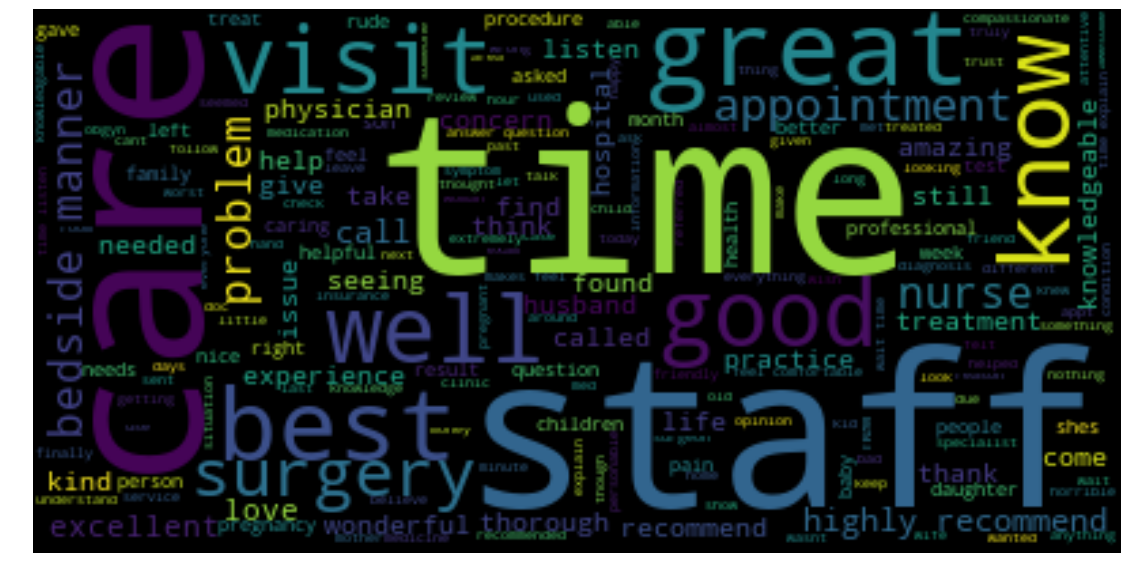

In [10]:
#Total reviews with "other" stop words stripped out
wordcloud = WordCloud().generate(pd.Series(reviews_all).str.cat(sep = " "))

pyplot.figure(figsize=(20,10))
pyplot.imshow(wordcloud, interpolation='bilinear')
pyplot.axis("off")

<Figure size 1440x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

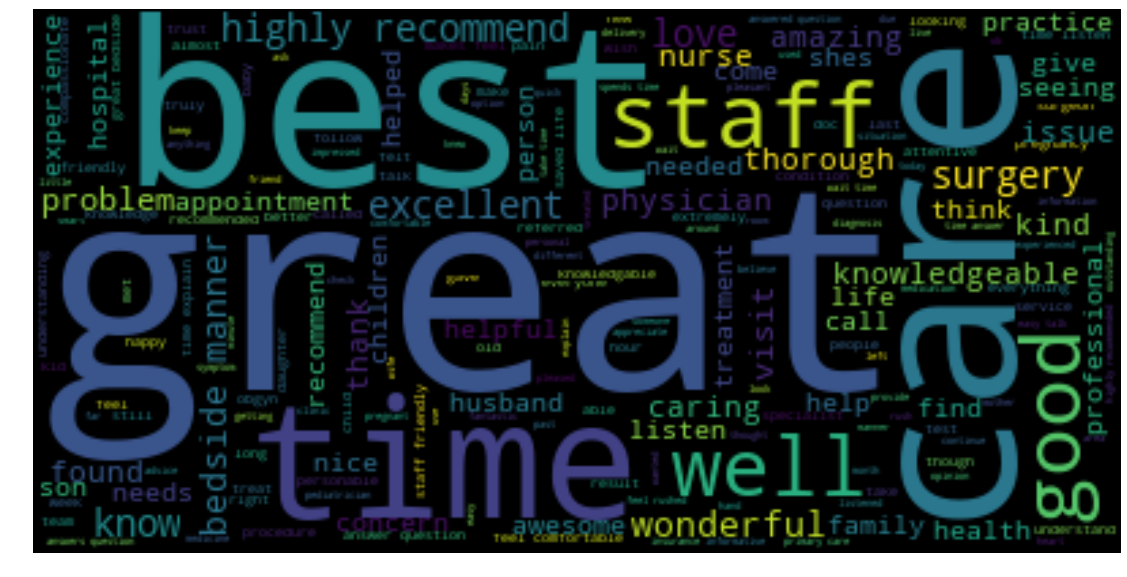

In [11]:
wordcloud = WordCloud().generate(pd.Series(reviews_good).str.cat(sep = " "))

pyplot.figure(figsize=(20,10))
pyplot.imshow(wordcloud, interpolation='bilinear')
pyplot.axis("off")

<Figure size 1440x720 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

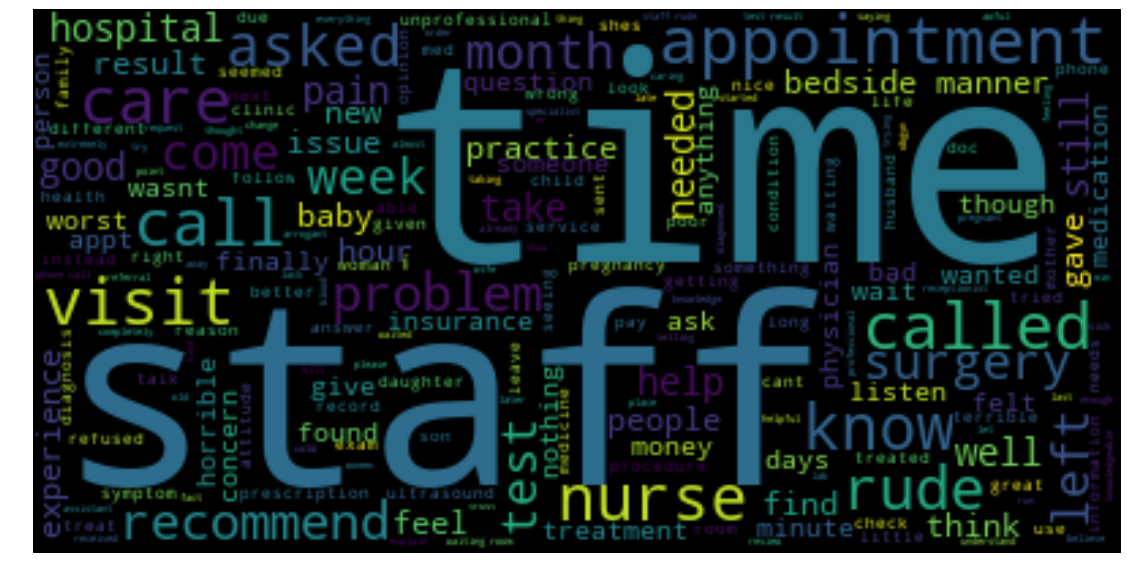

In [12]:
wordcloud = WordCloud().generate(pd.Series(reviews_bad).str.cat(sep = " "))

pyplot.figure(figsize=(20,10))
pyplot.imshow(wordcloud, interpolation='bilinear')
pyplot.axis("off")

## Text Analysis

In [9]:
vec = CountVectorizer(ngram_range=(1, 5), min_df = 2)
X = vec.fit_transform(reviews_all)

In [10]:
dtm = pd.DataFrame(X.toarray(), columns=[pd.Series(vec.get_feature_names()).str.replace(' ', '_').tolist()])
tdm = dtm.T
print(tdm.shape)

(317795, 16661)


### Calculate Fisher's Discriminant Score

In [15]:
len(dtm)

16661

In [ ]:
mask = pd.DataFrame(df_all.is_good)
good_df = dtm.iloc[np.any(mask.values,axis=1),]
bad_df = dtm.iloc[~np.any(mask.values,axis=1),]

# Make sure the good and bad reviews add up to 1
(len(bad_df) + len(good_df))/len(dtm)

In [ ]:
FiDi = pd.DataFrame(((good_df.mean() - bad_df.mean())**2)/(np.std(good_df)**2 + np.std(bad_df)**2)).reset_index().rename(columns = {"level_0":"term", 0:"FiDi_score"})

words = FiDi.term.tolist()
words = stopText(words)
words = stopOther(words)
#while("" in words) : 
 #   words.remove("")

words = pd.Series(words).str.lstrip(" ").tolist()

FiDi = FiDi[FiDi.term.isin(words)].sort_values(by = 'FiDi_score', ascending = False)
FiDi

### Create DF of most Frequent Words

In [445]:
tdm['total'] = tdm.sum(axis =1)
freq = tdm.reset_index().rename(columns = {"level_0":"allwords"})

words2 = freq.allwords.tolist()
words2 = stopText(words2)
words2 = stopOther(words2)

words2 = pd.Series(words2).str.lstrip(" ").tolist()

freq = freq[freq.allwords.isin(words2)].sort_values(by = 'total', ascending = False)[['allwords', 'total']]
freq

,allwords,total
40833,time,1088
36282,staff,892
14581,great,665
7729,care,634
32707,recommend,497
6279,best,471
14379,good,445
12085,family,419
7974,caring,388
38295,the_best,356


### Topic Analysis Using LDA

In [461]:
# Topic Analysis for all reviews
rvws_all = stopText(reviews_all)
rvws_all = stopOther(rvws_all)
clean_rvws_all = [i.split() for i in rvws]

# Creating the term dictionary of our reviews, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(clean_rvws_all)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_rvws_all]

In [462]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

#Results
print(ldamodel.print_topics(num_topics=5, num_words=7))

[(0, '0.011*"time" + 0.010*"patients" + 0.008*"would" + 0.008*"staff" + 0.008*"patient"'), (1, '0.015*"time" + 0.014*"would" + 0.009*"takes" + 0.009*"years" + 0.007*"staff"'), (2, '0.013*"manner" + 0.013*"best" + 0.012*"great" + 0.012*"bedside" + 0.011*"caring"'), (3, '0.012*"years" + 0.008*"heart" + 0.007*"office" + 0.007*"staff" + 0.007*"life"'), (4, '0.009*"staff" + 0.008*"one" + 0.007*"heart" + 0.007*"great" + 0.007*"well"')]


#### Topic Analysis for Good Reviews

In [403]:
# Topic Analysis for good reviews
rvws_g = stopText(reviews_good)
rvws_g = stopOther(rvws_g)
clean_rvws_g = [i.split() for i in rvws_g]

# Creating the term dictionary of our reviews, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(clean_rvws_g)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_rvws_g]

In [404]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix for good reviews
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

#Results
print(ldamodel.print_topics(num_topics=5, num_words=7))

[(0, '0.024*"time" + 0.022*"great" + 0.016*"staff" + 0.015*"patients" + 0.013*"excellent"'), (1, '0.010*"life" + 0.008*"patients" + 0.007*"best" + 0.006*"family" + 0.006*"lyme"'), (2, '0.019*"great" + 0.014*"family" + 0.013*"good" + 0.011*"best" + 0.011*"staff"'), (3, '0.017*"time" + 0.015*"care" + 0.013*"best" + 0.010*"caring" + 0.009*"feel"'), (4, '0.008*"good" + 0.007*"great" + 0.007*"recommend" + 0.006*"person" + 0.006*"patients"')]


#### Topic Analysis for Bad Reviews

In [405]:
# Topic Analysis for good reviews
rvws_b = stopText(reviews_bad)
rvws_b = stopOther(rvws_b)
clean_rvws_b = [i.split() for i in rvws_b]

# Creating the term dictionary of our reviews, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(clean_rvws_b)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_rvws_b]

In [406]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix for good reviews
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

#Results
print(ldamodel.print_topics(num_topics=5, num_words=7))

[(0, '0.009*"staff" + 0.009*"patients" + 0.009*"rude" + 0.006*"worst" + 0.006*"care"'), (1, '0.015*"staff" + 0.012*"time" + 0.011*"appointment" + 0.009*"called" + 0.009*"never"'), (2, '0.010*"staff" + 0.009*"never" + 0.008*"time" + 0.007*"care" + 0.006*"patients"'), (3, '0.008*"medical" + 0.007*"time" + 0.005*"practice" + 0.004*"feel" + 0.004*"family"'), (4, '0.011*"time" + 0.010*"’" + 0.009*"patients" + 0.006*"never" + 0.006*"staff"')]
